# Churn model for Insurance Company

The first attempt will be to try to predict the drivers of churn based on a classification method. The data contains flags relevant to customers demographics, claim and service behaviour and policy characteristics.

In [463]:
import pandas as pd

###### ** Changes from dataset version 2 to version 6:**

The data source had to be changed in order to address few issues/opportunities:
- the field AvgTurnaround had too many null values. Considering that only customers who claim will have this information, I couldn't find a way to keep the information in. So, for this reason it has been excluded from the datased
- the field CXMonthsFromRenewal also contained too many null values. The objective of the field is to provide the number of months that the policy is in the policy period, which expires every 12 months. There is a hypothesis that indicates that the customers are more likely to cancel when their policy is about to expiry
- the data size - reduce to only use policies with 0 to 5 years of tenure
- added data about latest claim and further demographics
- creation of a sudo policy no_ for privacy reasons

This version of the notebook has been created in order to address the changes to be made in the categorical variables


In [472]:
policies = pd.read_table('ChurnModelDatasetV6.txt',index_col='No_')

In [473]:
policies.shape
#policies.values            # underlying numpy array
#policies.info() 

(269202, 36)

**Interpreting the quantiles**
- Ntile5LastClaimAmount - 5 tile, 1 = lowest value
- Ntile5LastPaidAmount - 5 tile, 1 = lowest value
- PremiumDecile - 10 tile, 1 = lowest value

In [474]:
## remove columns that won't be used - most of them have similar variables in the data
policies.columns = [c.replace(' ', '_') for c in policies.columns]
policies.drop('premium', axis=1, inplace=True)
policies.drop('ClientAgeInMonths', axis=1, inplace=True)
policies.drop('PetAgeInMonths', axis=1, inplace=True)
policies.drop('petAgeInYears', axis=1, inplace=True)
policies.drop('ClientAgeInYears', axis=1, inplace=True)
policies.drop('Insured_Gender', axis=1, inplace=True)
policies.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269202 entries, 256909 to 56003
Data columns (total 30 columns):
Cancelled                      269202 non-null int64
PlanType                       269202 non-null object
ClaimedInThePast               269202 non-null int64
BenefitToClaimRatio            269202 non-null float64
irsd_decile                    267486 non-null float64
premium_payment_period_code    269202 non-null object
payment_method_code            269202 non-null object
InsuredGender                  269202 non-null object
PremiumDecile                  269202 non-null int64
breed_risk_group               269202 non-null int64
CXMonthsFromRenewal            269202 non-null int64
TenureInMonths                 269202 non-null int64
SalesChannel                   269202 non-null object
pet_agegroup_when_join         269202 non-null object
client_agegroup_when_join      269202 non-null object
NumberCalls                    269202 non-null int64
ClaimReviews              

In [475]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') # This styles the graphs in a nicer format

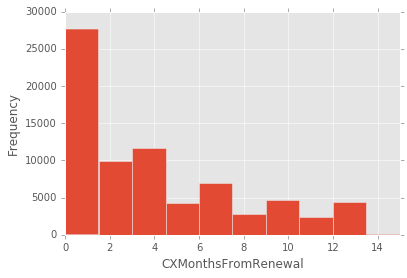

In [476]:
policies[policies.Cancelled == 1].CXMonthsFromRenewal.plot(kind='hist', xlim=(0,15))
#policies.CXMonthsFromRenewal.hist(by=policies.Cancelled, sharex=True, sharey=True)
plt.xlabel('CXMonthsFromRenewal')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 269202 entries, 256909 to 56003
Data columns (total 30 columns):
Cancelled                      269202 non-null int64
PlanType                       269202 non-null object
ClaimedInThePast               269202 non-null int64
BenefitToClaimRatio            269202 non-null float64
irsd_decile                    267486 non-null float64
premium_payment_period_code    269202 non-null object
payment_method_code            269202 non-null object
InsuredGender                  269202 non-null object
PremiumDecile                  269202 non-null int64
breed_risk_group               269202 non-null int64
CXMonthsFromRenewal            269202 non-null int64
TenureInMonths                 269202 non-null int64
SalesChannel                   269202 non-null object
pet_agegroup_when_join         269202 non-null object
client_agegroup_when_join      269202 non-null object
NumberCalls                    269202 non-null int64
ClaimReviews              

01-02     66063
00-01     49837
02-03     49485
03-04     24588
04-05     18400
05-06     15319
06-07     12601
07-08     10001
08-09      8506
09-10      5630
11-100     5382
10-11      3390
Name: PetAgeGroup, dtype: int64

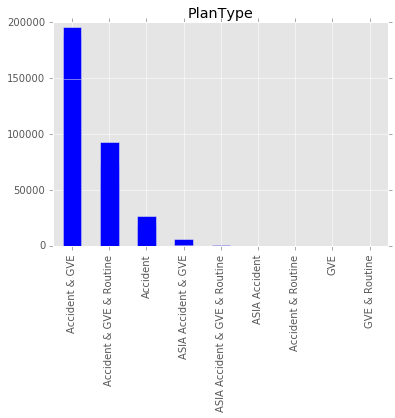

In [477]:
#transforming the string values into numeric values

policies.LastClaimStatus.value_counts().plot(kind='bar', title='Last Claim Status')
policies.InsuredGender.value_counts().plot(kind='bar', title='Gender')
policies.PlanType.value_counts().plot(kind='bar',title='PlanType')
policies.PlanType.value_counts()
policies.info()
policies.premium_payment_period_code.value_counts()
policies.payment_method_code.value_counts()
policies.species_code.value_counts()
policies.State.value_counts()
policies.ClientAgeInGroup.value_counts()
policies.PetAgeGroup.value_counts()

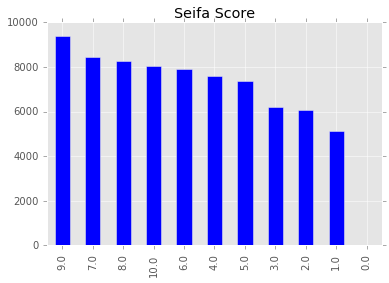

In [478]:
# check for missing values
policies.dropna(inplace=True)

policies.isnull().sum()

#policies[policies.Cancelled == 0].irsd_decile.value_counts().plot(kind='bar', title='Seifa Score')
policies[policies.Cancelled == 1].irsd_decile.value_counts().plot(kind='bar', title='Seifa Score')

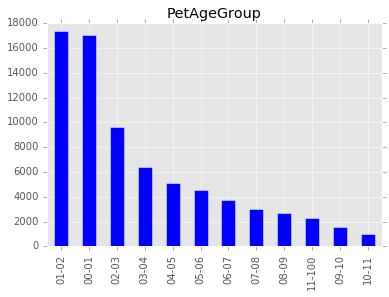

In [479]:
policies[policies.Cancelled == 1].PetAgeGroup.value_counts().plot(kind='bar', title='PetAgeGroup')


## Treating Categorical Data

In [480]:
# the categorical variables had been initially transformed to several numbers. In this version I will try to turn them into boolean values

policies.InsuredGender.value_counts()
policies['InsGenderFemale'] =  policies.InsuredGender.map({'Male':0, 'Female':1})

policies.InsGenderFemale.value_counts()

1    194503
0     72963
Name: InsGenderFemale, dtype: int64

In [481]:
#policies.species_code.replace(['CANINE','FELINE'],[1,2], inplace=True)
policies.species_code.value_counts()
policies['SpeciesDog'] =  policies.species_code.map({'FELINE':0, 'CANINE':1})
policies.SpeciesDog.value_counts()

1    225983
0     41483
Name: SpeciesDog, dtype: int64

In [482]:
#policies.LastClaimStatus.replace(['No Claims', 'Accepted with Pay', 'Denied', 'Accepted no Pay', 'Other'],  
[1, 2, 3, 4, 0], inplace=True)
policies.LastClaimStatus.value_counts()
policies['LastClaimAcceptedNoPay'] =  policies.LastClaimStatus.map({'No Claims':0,'Accepted with Pay':0,'Denied':0,
                                                                    'Accepted no Pay':1,'Other':0}) 
policies['LastClaimAcceptedPay'] =  policies.LastClaimStatus.map({'No Claims':0,'Accepted with Pay':1,'Denied':0,
                                                                  'Accepted no Pay':0,'Other':0}) 
policies['LastClaimDenied'] =  policies.LastClaimStatus.map({'No Claims':0,'Accepted with Pay':0,'Denied':1,
                                                             'Accepted no Pay':0,'Other':0}) 

policies.LastClaimDenied.value_counts()

0    249761
1     17705
Name: LastClaimDenied, dtype: int64

In [483]:
#policies.premium_payment_period_code.replace(['FORTNIGHTL','MONTHLY','ANNUALLY'],[1,2,3], inplace=True)
policies.premium_payment_period_code.value_counts()
policies['PayFreqFortnight'] =  policies.premium_payment_period_code.map({'FORTNIGHTL':1,'MONTHLY':0,'ANNUALLY':0}) 
policies['PayFreqMonth'] =  policies.premium_payment_period_code.map({'FORTNIGHTL':0,'MONTHLY':1,'ANNUALLY':0}) 
policies['PayFreqAnnual'] =  policies.premium_payment_period_code.map({'FORTNIGHTL':0,'MONTHLY':0,'ANNUALLY':1}) 

policies.PayFreqAnnual.value_counts()

0    239263
1     28203
Name: PayFreqAnnual, dtype: int64

In [484]:
#policies.payment_method_code.replace(['CC','BANK','CHEQUE'],[1,2,3], inplace=True)
policies.payment_method_code.value_counts()
policies['PayMethCC'] =  policies.payment_method_code.map({'CC':1,'BANK':0,'CHEQUE':0}) 

#due to low volumne of cheque, it has been put together with Bank
#policies['PayMethBank'] =  policies.payment_method_code.map({'CC':0,'BANK':1,'CHEQUE':1}) 

policies.PayMethCC.value_counts()

1    147304
0    120162
Name: PayMethCC, dtype: int64

In [485]:
#policies.State.replace(['NSW','VIC','QLD','WA','SA','ACT','TAS','NT'],[1,2,3,4,5,6,7,8], inplace=True)
policies.State.value_counts()
policies['StateNSW'] =  policies.State.map({'NSW':1,'VIC':0,'QLD':0,'WA':0,'SA':0,'ACT':0,'TAS':0,'NT':0}) 
policies['StateVIC'] =  policies.State.map({'NSW':0,'VIC':1,'QLD':0,'WA':0,'SA':0,'ACT':0,'TAS':0,'NT':0}) 
policies['StateQLD'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':1,'WA':0,'SA':0,'ACT':0,'TAS':0,'NT':0}) 
#policies['StateWA'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':1,'SA':0,'ACT':0,'TAS':0,'NT':0}) 
policies['StateSA'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':0,'SA':1,'ACT':0,'TAS':0,'NT':0}) 
policies['StateACT'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':0,'SA':0,'ACT':1,'TAS':0,'NT':0}) 
policies['StateTAS'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':0,'SA':0,'ACT':0,'TAS':1,'NT':0}) 
policies['StateNT'] =  policies.State.map({'NSW':0,'VIC':0,'QLD':0,'WA':0,'SA':0,'ACT':0,'TAS':0,'NT':1}) 

policies.StateNSW.value_counts()

0    199936
1     67530
Name: StateNSW, dtype: int64

In [486]:
#policies.PlanType.replace(['Accident & GVE', 'Accident & GVE & Routine','Accident','ASIA Accident & GVE',
#                         'ASIA Accident & GVE & Routine','ASIA Accident','Accident & Routine','GVE & Routine','GVE'], 
#                          [1, 2,3,1,2,3,4,4,4], inplace=True)

policies.PlanType.value_counts()
policies['PlanAccGVERout'] =  policies.PlanType.map({'Accident & GVE':0,'Accident & GVE & Routine':1,'Accident':0,
                                                     'ASIA Accident & GVE':0,'ASIA Accident & GVE & Routine':1,
                                                     'ASIA Accident':0,'Accident & Routine':0,'GVE':0,'GVE & Routine':0}) 

policies['PlanAccOnly'] =  policies.PlanType.map({'Accident & GVE':0,'Accident & GVE & Routine':0,'Accident':1,
                                                     'ASIA Accident & GVE':0,'ASIA Accident & GVE & Routine':0,
                                                     'ASIA Accident':1,'Accident & Routine':0,'GVE':0,'GVE & Routine':0}) 

policies['PlanAccGVE'] =  policies.PlanType.map({'Accident & GVE':1,'Accident & GVE & Routine':0,'Accident':0,
                                                     'ASIA Accident & GVE':1,'ASIA Accident & GVE & Routine':0,
                                                     'ASIA Accident':0,'Accident & Routine':0,'GVE':0,'GVE & Routine':0}) 

#policies['PlanOther'] =  policies.PlanType.map({'Accident & GVE':0,'Accident & GVE & Routine':0,'Accident':0,
#                                                     'ASIA Accident & GVE':0,'ASIA Accident & GVE & Routine':0,
#                                                     'ASIA Accident':0,'Accident & Routine':1,'GVE':1,'GVE & Routine':1}) 


policies.PlanAccOnly.value_counts()

0    240655
1     26811
Name: PlanAccOnly, dtype: int64

In [487]:
#policies.ClientAgeInGroup.replace(['00-19','20-29','30-39','40-49','50-59','60-100'],[1,2,3,4,5,6],inplace=True)

policies.ClientAgeInGroup.value_counts()
policies['ClientAge00to19'] =  policies.ClientAgeInGroup.map({'00-19':1,'20-29':0,'30-39':0,'40-49':0,'50-59':0,'60-100':0}) 
policies['ClientAge20to29'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':1,'30-39':0,'40-49':0,'50-59':0,'60-100':0}) 
policies['ClientAge30to39'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':0,'30-39':1,'40-49':0,'50-59':0,'60-100':0}) 
policies['ClientAge40to49'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':0,'30-39':0,'40-49':1,'50-59':0,'60-100':0}) 
policies['ClientAge50to59'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':0,'30-39':0,'40-49':0,'50-59':1,'60-100':0}) 
#policies['ClientAge60Plus'] =  policies.ClientAgeInGroup.map({'00-19':0,'20-29':0,'30-39':0,'40-49':0,'50-59':0,'60-100':1}) 


policies.ClientAge00to19.value_counts()


0    265007
1      2459
Name: ClientAge00to19, dtype: int64

In [491]:
#policies.PetAgeGroup.replace(['00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10',
#'10-11','11-100'],[1,2,3,4,5,6,7,8,9,10,11,12],inplace=True)     
policies.PetAgeGroup.value_counts()

policies['PetAge00to01'] =  policies.PetAgeGroup.map({'00-01':1,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,
                                                      '06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge01to02'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':1,'02-03':0,'03-04':0,'04-05':0,'05-06':0,
                                                      '06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge02to03'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':1,'03-04':0,'04-05':0,'05-06':0,
                                                      '06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge03to04'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':1,'04-05':0,'05-06':0,
                                                      '06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge04to05'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':1,'05-06':0,
                                                      '06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge05to06'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':1,
                                                      '06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge06to07'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,
                                                      '06-07':1,'07-08':0,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge07to08'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,
                                                      '06-07':0,'07-08':1,'08-09':0,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge08to09'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,
                                                      '06-07':0,'07-08':0,'08-09':1,'09-10':0,'10-11':0,'11-100':0}) 
policies['PetAge09to10'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,
                                                      '06-07':0,'07-08':0,'08-09':0,'09-10':1,'10-11':0,'11-100':0}) 
#policies['PetAge10Plus'] =  policies.PetAgeGroup.map({'00-01':0,'01-02':0,'02-03':0,'03-04':0,'04-05':0,'05-06':0,
#                                                      '06-07':0,'07-08':0,'08-09':0,'09-10':0,'10-11':1,'11-100':1}) 

policies.PetAge00to01.value_counts() ##48830

0    217915
1     49551
Name: PetAge00to01, dtype: int64

In [492]:
policies.irsd_decile.value_counts()
policies['IRSD_Dec10'] =  policies.irsd_decile.map({0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:1}) 
policies['IRSD_Dec89'] =  policies.irsd_decile.map({0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:1,9:1,10:0}) 
policies['IRSD_Dec67'] =  policies.irsd_decile.map({0:0,1:0,2:0,3:0,4:0,5:0,6:1,7:1,8:0,9:0,10:0}) 
policies['IRSD_Dec45'] =  policies.irsd_decile.map({0:0,1:0,2:0,3:0,4:1,5:1,6:0,7:0,8:0,9:0,10:0}) 
policies['IRSD_Dec23'] =  policies.irsd_decile.map({0:0,1:0,2:1,3:1,4:0,5:0,6:0,7:0,8:0,9:0,10:0}) 
policies.IRSD_Dec10.value_counts() #42226

0    225240
1     42226
Name: IRSD_Dec10, dtype: int64

In [493]:
policies.drop('irsd_decile',axis=1,inplace=True)

In [494]:
policies.drop('InsuredGender', axis=1, inplace=True)
policies.drop('species_code', axis=1, inplace=True)
policies.drop('LastClaimStatus', axis=1, inplace=True)
policies.drop('premium_payment_period_code', axis=1, inplace=True)
policies.drop('payment_method_code', axis=1, inplace=True)
policies.drop('State', axis=1, inplace=True)
policies.drop('PlanType', axis=1, inplace=True)
policies.drop('ClientAgeInGroup', axis=1, inplace=True)
policies.drop('PetAgeGroup', axis=1, inplace=True)
policies.drop('PayFreqAnnual', axis = 1, inplace=True)

In [495]:
policies.describe()

,Cancelled,ClaimedInThePast,BenefitToClaimRatio,PremiumDecile,breed_risk_group,CXMonthsFromRenewal,TenureInMonths,NumberCalls,ClaimReviews,MonthsSinceLastClaimReview,...,PetAge05to06,PetAge06to07,PetAge07to08,PetAge08to09,PetAge09to10,IRSD_Dec10,IRSD_Dec89,IRSD_Dec67,IRSD_Dec45,IRSD_Dec23
count,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,...,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000
mean,0.278043,0.306779,0.115534,5.501798,0.679137,4.804786,10.648909,1.811539,0.010132,13.471245,...,0.056916,0.046840,0.037141,0.031574,0.020911,0.157874,0.283636,0.218387,0.171786,0.124614
std,0.448035,0.461158,0.236117,2.871824,1.502114,3.687427,8.128869,2.996036,0.100147,8.240601,...,0.231682,0.211296,0.189108,0.174864,0.143087,0.364624,0.450763,0.413152,0.377195,0.330281
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,3.000000,0.000000,0.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,6.000000,0.000000,4.000000,9.000000,1.000000,0.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,8.000000,0.000000,8.000000,17.000000,2.000000,0.000000,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.100062,10.000000,6.000000,15.000000,37.000000,139.000000,1.000000,28.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [496]:
policies.SalesChannel.value_counts()
policies['ChannelWeb'] =  policies.SalesChannel.map({'Other':0, 'WEB':1})

policies.pet_agegroup_when_join.value_counts()
policies['PetAge00_01WhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':1,'1-2':0,'2-3':0,'3-4':0,'4-5':0,'5-6':0,
                                                                 '6-7':0,'7-8':0,'8-9':0,'9-10':0,'10-11':0,'11-100':0}) 
policies['PetAge01_02WhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':0,'1-2':1,'2-3':0,'3-4':0,'4-5':0,'5-6':0,
                                                                 '6-7':0,'7-8':0,'8-9':0,'9-10':0,'10-11':0,'11-100':0}) 
policies['PetAge02_03WhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':0,'1-2':0,'2-3':1,'3-4':0,'4-5':0,'5-6':0,
                                                                 '6-7':0,'7-8':0,'8-9':0,'9-10':0,'10-11':0,'11-100':0}) 
policies['PetAge03_04WhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':0,'1-2':0,'2-3':0,'3-4':1,'4-5':0,'5-6':0,
                                                                 '6-7':0,'7-8':0,'8-9':0,'9-10':0,'10-11':0,'11-100':0}) 
policies['PetAge04_05WhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':0,'1-2':0,'2-3':0,'3-4':0,'4-5':1,'5-6':0,
                                                                 '6-7':0,'7-8':0,'8-9':0,'9-10':0,'10-11':0,'11-100':0}) 
policies['PetAge05_06WhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':0,'1-2':0,'2-3':0,'3-4':0,'4-5':0,'5-6':1,
                                                                 '6-7':0,'7-8':0,'8-9':0,'9-10':0,'10-11':0,'11-100':0}) 
policies['PetAge06_07WhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':0,'1-2':0,'2-3':0,'3-4':0,'4-5':0,'5-6':0,
                                                                 '6-7':1,'7-8':0,'8-9':0,'9-10':0,'10-11':0,'11-100':0}) 
policies['PetAge07_08WhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':0,'1-2':0,'2-3':0,'3-4':0,'4-5':0,'5-6':0,
                                                                 '6-7':0,'7-8':1,'8-9':0,'9-10':0,'10-11':0,'11-100':0}) 
policies['PetAge08_09WhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':0,'1-2':0,'2-3':0,'3-4':0,'4-5':0,'5-6':0,
                                                                 '6-7':0,'7-8':0,'8-9':1,'9-10':0,'10-11':0,'11-100':0}) 
policies['PetAge10PlusWhenJoin'] =  policies.pet_agegroup_when_join.map({'0-1':0,'1-2':0,'2-3':0,'3-4':0,'4-5':0,'5-6':0,
                                                                 '6-7':0,'7-8':0,'8-9':0,'9-10':1,'10-11':1,'11-100':1}) 


In [497]:
policies.client_agegroup_when_join.value_counts()     
policies['ClientAge00to19WhenJoined'] =  policies.client_agegroup_when_join.map({'0-19':1,'20-29':0,'30-39':0,
                                                                                 '40-49':0,'50-59':0,'60-100':0}) 
policies['ClientAge20to29WhenJoined'] =  policies.client_agegroup_when_join.map({'0-19':0,'20-29':1,'30-39':0,
                                                                                 '40-49':0,'50-59':0,'60-100':0}) 
policies['ClientAge30to39WhenJoined'] =  policies.client_agegroup_when_join.map({'0-19':0,'20-29':0,'30-39':1,
                                                                                 '40-49':0,'50-59':0,'60-100':0}) 
policies['ClientAge40to49WhenJoined'] =  policies.client_agegroup_when_join.map({'0-19':0,'20-29':0,'30-39':0,
                                                                                 '40-49':1,'50-59':0,'60-100':0}) 
policies['ClientAge50to59WhenJoined'] =  policies.client_agegroup_when_join.map({'0-19':0,'20-29':0,'30-39':0,
                                                                                 '40-49':0,'50-59':1,'60-100':0}) 

In [498]:
policies.LastReviewOutcome.value_counts()   
policies['LastReviewOutcomeNoReview'] =  policies.LastReviewOutcome.map({'No review':1,'Claim Decision Upheld':0,
                                                                         'Claim Decision Reversed':0,
                                                                         'Ex-gratia Claim':0,'PENDING':0,
                                                                         'Exclusion Removed':0,
                                                                         'Underwriting Reversed':0,
                                                                         'Service Issue Resolved':0,
                                                                         'Reponse Prepared and Sent':0,
                                                                         'Underwriting Maintained':0,
                                                                         'Exclusion Maintained':0}) 
policies['LastReviewOutcomeUpheld'] =  policies.LastReviewOutcome.map({'No review':0,'Claim Decision Upheld':1,
                                                                         'Claim Decision Reversed':0,
                                                                         'Ex-gratia Claim':0,'PENDING':0,
                                                                         'Exclusion Removed':0,
                                                                         'Underwriting Reversed':0,
                                                                         'Service Issue Resolved':0,
                                                                         'Reponse Prepared and Sent':0,
                                                                         'Underwriting Maintained':1,
                                                                         'Exclusion Maintained':1}) 
policies['LastReviewOutcomeReversed'] =  policies.LastReviewOutcome.map({'No review':0,'Claim Decision Upheld':0,
                                                                         'Claim Decision Reversed':1,
                                                                         'Ex-gratia Claim':1,'PENDING':0,
                                                                         'Exclusion Removed':1,
                                                                         'Underwriting Reversed':1,
                                                                         'Service Issue Resolved':0,
                                                                         'Reponse Prepared and Sent':0,
                                                                         'Underwriting Maintained':0,
                                                                         'Exclusion Maintained':0})




In [499]:
policies.drop('SalesChannel', axis = 1, inplace=True)
policies.drop('pet_agegroup_when_join', axis = 1, inplace=True)
policies.drop('client_agegroup_when_join', axis = 1, inplace=True)
policies.drop('LastReviewOutcome', axis = 1, inplace=True)

In [500]:
policies.Ntile5LastClaimAmount.value_counts()
policies['Ntile5LastClaimAmount0'] =  policies.Ntile5LastClaimAmount.map({0:1, 1:0, 2:0, 3:0, 4:0, 5:0})
policies['Ntile5LastClaimAmount1'] =  policies.Ntile5LastClaimAmount.map({0:0, 1:1, 2:0, 3:0, 4:0, 5:0})
policies['Ntile5LastClaimAmount2'] =  policies.Ntile5LastClaimAmount.map({0:0, 1:0, 2:1, 3:0, 4:0, 5:0})
policies['Ntile5LastClaimAmount3'] =  policies.Ntile5LastClaimAmount.map({0:0, 1:0, 2:0, 3:1, 4:0, 5:0})
policies['Ntile5LastClaimAmount4'] =  policies.Ntile5LastClaimAmount.map({0:0, 1:0, 2:0, 3:0, 4:1, 5:0})

policies['Ntile5LastPaidAmount0'] =  policies.Ntile5LastPaidAmount.map({0:1, 1:0, 2:0, 3:0, 4:0, 5:0})
policies['Ntile5LastPaidAmount1'] =  policies.Ntile5LastPaidAmount.map({0:0, 1:1, 2:0, 3:0, 4:0, 5:0})
policies['Ntile5LastPaidAmount2'] =  policies.Ntile5LastPaidAmount.map({0:0, 1:0, 2:1, 3:0, 4:0, 5:0})
policies['Ntile5LastPaidAmount3'] =  policies.Ntile5LastPaidAmount.map({0:0, 1:0, 2:0, 3:1, 4:0, 5:0})
policies['Ntile5LastPaidAmount4'] =  policies.Ntile5LastPaidAmount.map({0:0, 1:0, 2:0, 3:0, 4:1, 5:0})

policies.drop('Ntile5LastClaimAmount', axis = 1, inplace=True)
policies.drop('Ntile5LastPaidAmount', axis = 1, inplace=True)

In [501]:
policies.PremiumDecile.value_counts()
policies['PremiumDecile0'] =  policies.PremiumDecile.map({0:1, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0,
                                                                 9:0, 10:0})
policies['PremiumDecile1'] =  policies.PremiumDecile.map({0:0, 1:1, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0,
                                                                 9:0, 10:0})
policies['PremiumDecile2'] =  policies.PremiumDecile.map({0:0, 1:0, 2:1, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0,
                                                                 9:0, 10:0})
policies['PremiumDecile3'] =  policies.PremiumDecile.map({0:0, 1:0, 2:0, 3:1, 4:0, 5:0, 6:0, 7:0, 8:0,
                                                                 9:0, 10:0})
policies['PremiumDecile4'] =  policies.PremiumDecile.map({0:0, 1:0, 2:0, 3:0, 4:1, 5:0, 6:0, 7:0, 8:0,
                                                                 9:0, 10:0})
policies['PremiumDecile5'] =  policies.PremiumDecile.map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:0, 7:0, 8:0,
                                                                 9:0, 10:0})
policies['PremiumDecile6'] =  policies.PremiumDecile.map({0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:0, 8:0,
                                                                 9:0, 10:0})
policies['PremiumDecile7'] =  policies.PremiumDecile.map({0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:1, 8:0,
                                                                 9:0, 10:0})
policies['PremiumDecile8'] =  policies.PremiumDecile.map({0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:1,
                                                                 9:0, 10:0})
policies['PremiumDecile9'] =  policies.PremiumDecile.map({0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0,
                                                                 9:1, 10:0})
policies.drop('PremiumDecile', axis = 1, inplace=True)

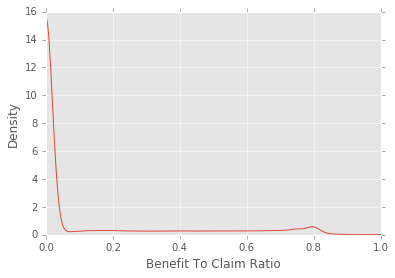

In [502]:
policies.BenefitToClaimRatio.plot(by=policies.Cancelled ,kind='density', xlim=(0,1))
plt.xlabel('Benefit To Claim Ratio')

In [503]:
policies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267466 entries, 256909 to 56003
Data columns (total 90 columns):
Cancelled                     267466 non-null int64
ClaimedInThePast              267466 non-null int64
BenefitToClaimRatio           267466 non-null float64
breed_risk_group              267466 non-null int64
CXMonthsFromRenewal           267466 non-null int64
TenureInMonths                267466 non-null int64
NumberCalls                   267466 non-null int64
ClaimReviews                  267466 non-null int64
MonthsSinceLastClaimReview    267466 non-null int64
PortalUser                    267466 non-null int64
OtherMembershipNumber         267466 non-null int64
OtherPets                     267466 non-null int64
MOnthsSinceLastClaim          267466 non-null int64
InsGenderFemale               267466 non-null int64
SpeciesDog                    267466 non-null int64
LastClaimAcceptedNoPay        267466 non-null int64
LastClaimAcceptedPay          267466 non-null int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1ca21f810>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c8490f90>], dtype=object)

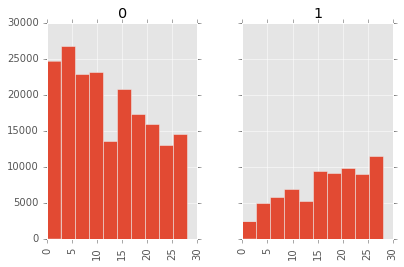

In [505]:
policies.MonthsSinceLastClaimReview.hist(by=policies.Cancelled, sharex=True, sharey=True)

In [506]:
policies.drop('PremiumDecile0', axis = 1, inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c871ba90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c7f1c790>], dtype=object)

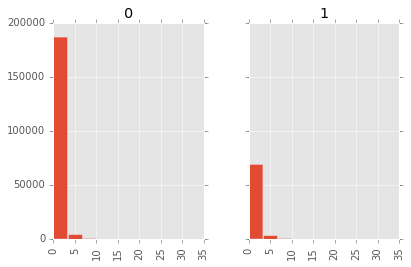

In [507]:
policies.OtherPets.hist(by=policies.Cancelled, sharex=True, sharey=True)

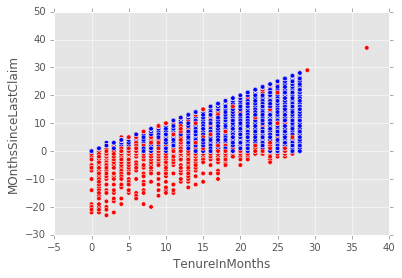

In [508]:
colors = np.where(policies.Cancelled==1, 'r', 'b') #cancelled red
policies.plot(kind='scatter', x='TenureInMonths', y='MOnthsSinceLastClaim', c=colors)

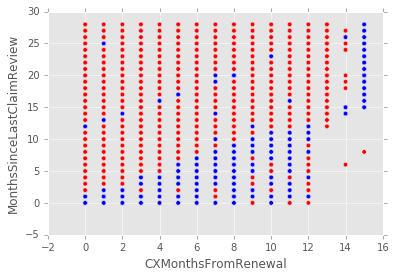

In [509]:
colors = np.where(policies.Cancelled==1, 'r', 'b') #cancelled red
policies.plot(kind='scatter', x='CXMonthsFromRenewal', y='MonthsSinceLastClaimReview', c=colors)

In [510]:
policies.OtherPets.value_counts()
policies['MultiplePetsOwner'] =  policies.OtherPets.map({0:0,1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,10:1,
                                                        11:1,12:1,13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1,
                                                        21:1,22:1,23:1,24:1,25:1,26:1,27:1,28:1,29:1,30:1,
                                                        31:1,32:1,33:1})

In [511]:
policies.MultiplePetsOwner.value_counts()

0    149589
1    117877
Name: MultiplePetsOwner, dtype: int64

In [512]:
policies.drop('OtherPets', axis = 1, inplace=True)

## Trying Logistic Regression

In [513]:
# compute null accuracy manually for comparison reasosn
print policies['Cancelled'].mean()
print 1 - policies['Cancelled'].mean()

0.278042816657
0.721957183343


In [514]:
#pd.scatter_matrix(policies, figsize=(30,30))

In [515]:
import statsmodels.formula.api as smf

In [516]:
policies.describe()

,Cancelled,ClaimedInThePast,BenefitToClaimRatio,breed_risk_group,CXMonthsFromRenewal,TenureInMonths,NumberCalls,ClaimReviews,MonthsSinceLastClaimReview,PortalUser,...,PremiumDecile1,PremiumDecile2,PremiumDecile3,PremiumDecile4,PremiumDecile5,PremiumDecile6,PremiumDecile7,PremiumDecile8,PremiumDecile9,MultiplePetsOwner
count,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,...,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000
mean,0.278043,0.306779,0.115534,0.679137,4.804786,10.648909,1.811539,0.010132,13.471245,0.170807,...,0.099830,0.099904,0.099983,0.099987,0.100069,0.099998,0.100013,0.100147,0.100035,0.440718
std,0.448035,0.461158,0.236117,1.502114,3.687427,8.128869,2.996036,0.100147,8.240601,0.376341,...,0.299773,0.299873,0.299978,0.299983,0.300092,0.299998,0.300018,0.300197,0.300047,0.496474
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,4.000000,9.000000,1.000000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,8.000000,17.000000,2.000000,0.000000,20.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.100062,6.000000,15.000000,37.000000,139.000000,1.000000,28.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [517]:
policies.corr()

,Cancelled,ClaimedInThePast,BenefitToClaimRatio,breed_risk_group,CXMonthsFromRenewal,TenureInMonths,NumberCalls,ClaimReviews,MonthsSinceLastClaimReview,PortalUser,...,PremiumDecile1,PremiumDecile2,PremiumDecile3,PremiumDecile4,PremiumDecile5,PremiumDecile6,PremiumDecile7,PremiumDecile8,PremiumDecile9,MultiplePetsOwner
Cancelled,1.000000,-0.144660,-0.151530,0.080752,-0.154870,-0.330987,0.089710,-0.006041,0.242609,-0.144825,...,0.015059,-0.004163,-0.008691,-0.009700,0.003898,-0.001489,-0.010087,-0.013445,0.006444,0.141982
ClaimedInThePast,-0.144660,1.000000,0.735539,0.110429,0.131931,0.347617,0.237824,0.151518,0.211426,0.238324,...,0.067578,0.065145,0.044678,0.060263,0.025181,0.006807,-0.005009,-0.047651,-0.095604,-0.099731
BenefitToClaimRatio,-0.151530,0.735539,1.000000,0.115206,0.101824,0.332126,0.230810,0.086328,0.208990,0.176307,...,0.077967,0.069438,0.045044,0.058640,0.026434,0.003094,-0.009378,-0.056407,-0.094421,-0.061076
breed_risk_group,0.080752,0.110429,0.115206,1.000000,-0.093097,0.332741,0.209098,0.027328,0.462565,-0.030644,...,0.062998,0.032378,0.009895,0.030226,-0.014516,-0.002408,-0.011465,-0.033284,-0.047948,0.137856
CXMonthsFromRenewal,-0.154870,0.131931,0.101824,-0.093097,1.000000,0.322144,0.059321,0.022446,0.175447,0.012688,...,-0.030937,-0.022092,-0.004737,-0.012406,-0.000031,0.004895,0.010017,0.023697,0.017809,-0.002032
TenureInMonths,-0.330987,0.347617,0.332126,0.332741,0.322144,1.000000,0.135289,0.060060,0.713382,-0.008707,...,0.038171,0.041889,0.003120,0.053190,-0.017454,-0.010028,0.025444,-0.043644,-0.053725,-0.051646
NumberCalls,0.089710,0.237824,0.230810,0.209098,0.059321,0.135289,1.000000,0.122873,0.162168,0.136947,...,0.040484,0.026063,0.014414,0.013986,0.004687,0.002082,-0.014108,-0.022979,-0.032634,0.270294
ClaimReviews,-0.006041,0.151518,0.086328,0.027328,0.022446,0.060060,0.122873,1.000000,-0.050831,0.049611,...,0.022848,0.014474,0.003864,0.002369,-0.002387,-0.006221,-0.003613,-0.009377,-0.014943,-0.011757
MonthsSinceLastClaimReview,0.242609,0.211426,0.208990,0.462565,0.175447,0.713382,0.162168,-0.050831,1.000000,-0.130956,...,0.021686,0.026406,-0.015551,0.048592,-0.019945,-0.005447,0.032564,-0.035021,-0.042367,0.048570
PortalUser,-0.144825,0.238324,0.176307,-0.030644,0.012688,-0.008707,0.136947,0.049611,-0.130956,1.000000,...,-0.023354,-0.010937,0.004215,-0.005792,0.009910,0.017902,0.015097,0.029479,-0.011062,0.015924


In [518]:
#lm = smf.ols(formula='Cancelled ~ CXMonthsFromRenewal + OtherPets + MOnthsSinceLastClaim + LastClaimStatus 
#            + PetAgeGroup', data=policies).fit()

# print the coefficients
#lm.params

In [519]:
#lm.summary()

In [520]:
policies.Cancelled.value_counts()
# cancelled policies make up to 72.4% of the dataset so the model isn't really predicting any better

0    193099
1     74367
Name: Cancelled, dtype: int64

In [521]:
! pip install seaborn

You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


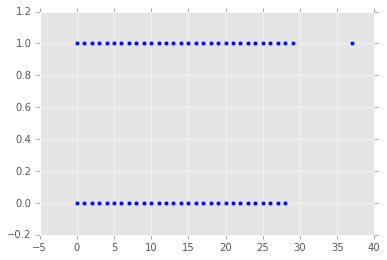

In [522]:
plt.scatter(policies.TenureInMonths, policies.Cancelled)

In [523]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)

feature_cols = ['ClaimedInThePast','BenefitToClaimRatio','breed_risk_group','CXMonthsFromRenewal',
                'TenureInMonths','NumberCalls','ClaimReviews','MonthsSinceLastClaimReview','PortalUser',
                'OtherMembershipNumber','MultiplePetsOwner','MOnthsSinceLastClaim','InsGenderFemale','SpeciesDog',
                'PayFreqFortnight','PayFreqMonth','PayMethCC','StateNSW','StateVIC','StateQLD','StateSA','StateACT',
                'StateTAS','StateNT','PlanAccGVERout','PlanAccOnly','PlanAccGVE','PetAge00to01',
                'PetAge01to02','PetAge02to03','PetAge03to04','PetAge04to05','PetAge05to06','PetAge06to07',
                'PetAge07to08','PetAge08to09','PetAge09to10','IRSD_Dec10','IRSD_Dec89','IRSD_Dec67','IRSD_Dec45',
                'IRSD_Dec23','ChannelWeb','PetAge00_01WhenJoin','PetAge01_02WhenJoin','PetAge02_03WhenJoin',
                'PetAge03_04WhenJoin','PetAge04_05WhenJoin','PetAge05_06WhenJoin','PetAge06_07WhenJoin',
                'PetAge07_08WhenJoin','PetAge08_09WhenJoin','PetAge10PlusWhenJoin','ClientAge00to19WhenJoined',
                'ClientAge20to29WhenJoined','ClientAge30to39WhenJoined','ClientAge40to49WhenJoined',
                'ClientAge50to59WhenJoined','LastReviewOutcomeNoReview','LastReviewOutcomeUpheld',
                'LastReviewOutcomeReversed','Ntile5LastClaimAmount0','Ntile5LastClaimAmount1',
                'Ntile5LastClaimAmount2','Ntile5LastClaimAmount3','Ntile5LastClaimAmount4',
                'Ntile5LastPaidAmount0','Ntile5LastPaidAmount1','Ntile5LastPaidAmount2','Ntile5LastPaidAmount3',
                'Ntile5LastPaidAmount4','PremiumDecile1','PremiumDecile2','PremiumDecile3','PremiumDecile4',
                'PremiumDecile5','PremiumDecile6','PremiumDecile7','PremiumDecile8','PremiumDecile9'] 
X = policies[feature_cols]
y = policies.Cancelled
logreg.fit(X, y)
policies_pred_class = logreg.predict(X)

In [524]:
#policies_pred_class
policies_pred_class_prob = logreg.predict_proba(X)[:, 1]
policies_pred_class_prob

array([ 0.76772883,  0.7637747 ,  0.78964085, ...,  0.01893245,
        0.01473434,  1.        ])

In [525]:
zip(feature_cols, logreg.coef_[0])

[('ClaimedInThePast', -0.25010701868168628),
 ('BenefitToClaimRatio', -1.0707241129951095),
 ('breed_risk_group', -0.0066692684676304178),
 ('CXMonthsFromRenewal', -0.010235232497541925),
 ('TenureInMonths', -3.9098444562406827),
 ('NumberCalls', 0.056027382129132275),
 ('ClaimReviews', 6.3517549230625807),
 ('MonthsSinceLastClaimReview', 3.8991377104010065),
 ('PortalUser', -0.13534240908012768),
 ('OtherMembershipNumber', -0.18101654001761225),
 ('MultiplePetsOwner', 0.21257874781550992),
 ('MOnthsSinceLastClaim', -0.033636245645412483),
 ('InsGenderFemale', -0.015014596127214052),
 ('SpeciesDog', -0.38896381475335035),
 ('PayFreqFortnight', 0.27343696950451979),
 ('PayFreqMonth', 0.15647303779004484),
 ('PayMethCC', 0.15804458472085767),
 ('StateNSW', 0.030991400341384798),
 ('StateVIC', 0.014555077692738824),
 ('StateQLD', 0.090367625549899258),
 ('StateSA', -0.048622565409294036),
 ('StateACT', -0.020245679550618713),
 ('StateTAS', -0.026914150430773963),
 ('StateNT', 0.3271864977

In [533]:
#policies.ClaimReviews.hist(by=policies.Cancelled, sharex=True, sharey=True)
#policies[policies.Cancelled==0].ClaimReviews.value_counts()
policies.groupby('Cancelled').ClaimReviews.value_counts() 
#policies.groupby('Cancelled').MonthsSinceLastClaimReview.value_counts() 

Cancelled  ClaimReviews
0          0               191070
           1                 2029
1          0                73686
           1                  681
dtype: int64

In [534]:
from sklearn import metrics
prds = logreg.predict(X)
print metrics.confusion_matrix(y, prds)

[[192824    275]
 [  4871  69496]]


In [535]:
print metrics.accuracy_score(y, prds)

0.980760171386


Considering the extremely high accuracy, and the very high coeficient of claimreviews column with a very poorly populated column, I will try it again not including this column. Also, MonthsSinceLastClaimReview hasn't been treated and have very not regularised information

In [536]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)

feature_cols = ['ClaimedInThePast','BenefitToClaimRatio','breed_risk_group','CXMonthsFromRenewal',
                'TenureInMonths','NumberCalls',#'ClaimReviews','MonthsSinceLastClaimReview',
                'PortalUser',
                'OtherMembershipNumber','MultiplePetsOwner','MOnthsSinceLastClaim','InsGenderFemale','SpeciesDog',
                'PayFreqFortnight','PayFreqMonth','PayMethCC','StateNSW','StateVIC','StateQLD','StateSA','StateACT',
                'StateTAS','StateNT','PlanAccGVERout','PlanAccOnly','PlanAccGVE','PetAge00to01',
                'PetAge01to02','PetAge02to03','PetAge03to04','PetAge04to05','PetAge05to06','PetAge06to07',
                'PetAge07to08','PetAge08to09','PetAge09to10','IRSD_Dec10','IRSD_Dec89','IRSD_Dec67','IRSD_Dec45',
                'IRSD_Dec23','ChannelWeb','PetAge00_01WhenJoin','PetAge01_02WhenJoin','PetAge02_03WhenJoin',
                'PetAge03_04WhenJoin','PetAge04_05WhenJoin','PetAge05_06WhenJoin','PetAge06_07WhenJoin',
                'PetAge07_08WhenJoin','PetAge08_09WhenJoin','PetAge10PlusWhenJoin','ClientAge00to19WhenJoined',
                'ClientAge20to29WhenJoined','ClientAge30to39WhenJoined','ClientAge40to49WhenJoined',
                'ClientAge50to59WhenJoined','LastReviewOutcomeNoReview','LastReviewOutcomeUpheld',
                'LastReviewOutcomeReversed','Ntile5LastClaimAmount0','Ntile5LastClaimAmount1',
                'Ntile5LastClaimAmount2','Ntile5LastClaimAmount3','Ntile5LastClaimAmount4',
                'Ntile5LastPaidAmount0','Ntile5LastPaidAmount1','Ntile5LastPaidAmount2','Ntile5LastPaidAmount3',
                'Ntile5LastPaidAmount4','PremiumDecile1','PremiumDecile2','PremiumDecile3','PremiumDecile4',
                'PremiumDecile5','PremiumDecile6','PremiumDecile7','PremiumDecile8','PremiumDecile9'] 
X = policies[feature_cols]
y = policies.Cancelled
logreg.fit(X, y)
policies_pred_class = logreg.predict(X)

In [537]:
policies_pred_class_prob = logreg.predict_proba(X)[:, 1]
policies_pred_class_prob

array([ 0.65926136,  0.64684449,  0.66401143, ...,  0.27292898,
        0.1440452 ,  0.28759837])

In [538]:
zip(feature_cols, logreg.coef_[0])

[('ClaimedInThePast', -1.1088178983156642),
 ('BenefitToClaimRatio', -0.7330464341854005),
 ('breed_risk_group', 0.32295855557751707),
 ('CXMonthsFromRenewal', -0.00038928325037327103),
 ('TenureInMonths', -0.13019087722480799),
 ('NumberCalls', 0.11013577513124032),
 ('PortalUser', -1.2452534130662039),
 ('OtherMembershipNumber', -0.50297947235850904),
 ('MultiplePetsOwner', 0.19220670165666565),
 ('MOnthsSinceLastClaim', -0.007321595401397484),
 ('InsGenderFemale', 0.021903026385255937),
 ('SpeciesDog', -0.42661843474720684),
 ('PayFreqFortnight', 0.55972214403558562),
 ('PayFreqMonth', 0.34458844747893008),
 ('PayMethCC', 0.25314324459228971),
 ('StateNSW', 0.052138986567381557),
 ('StateVIC', -0.01170792000020043),
 ('StateQLD', 0.15280074008801409),
 ('StateSA', 0.013940352697238005),
 ('StateACT', 0.077171365606653594),
 ('StateTAS', 0.060217610947916805),
 ('StateNT', 0.27870547281654612),
 ('PlanAccGVERout', 1.7675251376055934),
 ('PlanAccOnly', 1.8070827239103395),
 ('PlanAccG

In [539]:
from sklearn import metrics
prds = logreg.predict(X)
print metrics.confusion_matrix(y, prds)

[[176423  16676]
 [ 40408  33959]]


In [540]:
print metrics.accuracy_score(y, prds)

0.78657474221


In [541]:
policies.describe()

,Cancelled,ClaimedInThePast,BenefitToClaimRatio,breed_risk_group,CXMonthsFromRenewal,TenureInMonths,NumberCalls,ClaimReviews,MonthsSinceLastClaimReview,PortalUser,...,PremiumDecile1,PremiumDecile2,PremiumDecile3,PremiumDecile4,PremiumDecile5,PremiumDecile6,PremiumDecile7,PremiumDecile8,PremiumDecile9,MultiplePetsOwner
count,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,...,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000
mean,0.278043,0.306779,0.115534,0.679137,4.804786,10.648909,1.811539,0.010132,13.471245,0.170807,...,0.099830,0.099904,0.099983,0.099987,0.100069,0.099998,0.100013,0.100147,0.100035,0.440718
std,0.448035,0.461158,0.236117,1.502114,3.687427,8.128869,2.996036,0.100147,8.240601,0.376341,...,0.299773,0.299873,0.299978,0.299983,0.300092,0.299998,0.300018,0.300197,0.300047,0.496474
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,4.000000,9.000000,1.000000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,8.000000,17.000000,2.000000,0.000000,20.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.100062,6.000000,15.000000,37.000000,139.000000,1.000000,28.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [542]:
feature_cols = ['ClaimedInThePast','BenefitToClaimRatio','breed_risk_group','CXMonthsFromRenewal',
                'TenureInMonths','NumberCalls',#'ClaimReviews','MonthsSinceLastClaimReview',
                'PortalUser',
                'OtherMembershipNumber','MultiplePetsOwner','MOnthsSinceLastClaim','InsGenderFemale','SpeciesDog',
                'PayFreqFortnight','PayFreqMonth','PayMethCC','StateNSW','StateVIC','StateQLD','StateSA','StateACT',
                'StateTAS','StateNT','PlanAccGVERout','PlanAccOnly','PlanAccGVE','PetAge00to01',
                'PetAge01to02','PetAge02to03','PetAge03to04','PetAge04to05','PetAge05to06','PetAge06to07',
                'PetAge07to08','PetAge08to09','PetAge09to10','IRSD_Dec10','IRSD_Dec89','IRSD_Dec67','IRSD_Dec45',
                'IRSD_Dec23','ChannelWeb','PetAge00_01WhenJoin','PetAge01_02WhenJoin','PetAge02_03WhenJoin',
                'PetAge03_04WhenJoin','PetAge04_05WhenJoin','PetAge05_06WhenJoin','PetAge06_07WhenJoin',
                'PetAge07_08WhenJoin','PetAge08_09WhenJoin','PetAge10PlusWhenJoin','ClientAge00to19WhenJoined',
                'ClientAge20to29WhenJoined','ClientAge30to39WhenJoined','ClientAge40to49WhenJoined',
                'ClientAge50to59WhenJoined','LastReviewOutcomeNoReview','LastReviewOutcomeUpheld',
                'LastReviewOutcomeReversed','Ntile5LastClaimAmount0','Ntile5LastClaimAmount1',
                'Ntile5LastClaimAmount2','Ntile5LastClaimAmount3','Ntile5LastClaimAmount4',
                'Ntile5LastPaidAmount0','Ntile5LastPaidAmount1','Ntile5LastPaidAmount2','Ntile5LastPaidAmount3',
                'Ntile5LastPaidAmount4','PremiumDecile1','PremiumDecile2','PremiumDecile3','PremiumDecile4',
                'PremiumDecile5','PremiumDecile6','PremiumDecile7','PremiumDecile8','PremiumDecile9']
X = policies[feature_cols]
y = policies.Cancelled

In [543]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [544]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
Cancelled_pred_class = logreg.predict_proba(X_train)[:, 1]
Cancelled_pred_class

array([ 0.36212446,  0.37506472,  0.18299028, ...,  0.74373427,
        0.21002028,  0.32055895])

In [545]:
import numpy as np
print 'no regularization =', np.sqrt(metrics.mean_squared_error(y_train, Cancelled_pred_class))

no regularization = 0.385949114273


In [546]:
from sklearn import metrics
prds = logreg.predict(X_test)
print metrics.confusion_matrix(y_test, prds)

[[44005  4209]
 [10176  8477]]


In [547]:
print metrics.accuracy_score(y_test, prds)

0.784871461259


## Trying Regularization

In [548]:
########## Ridge Regression Model ##########
# ridge regression (alpha must be positive, larger means more regularization)
from sklearn.linear_model import Ridge
rreg = Ridge(alpha=0.1, normalize=True)
rreg.fit(X_train, y_train)
rreg.coef_
preds = rreg.predict(X_test)
print 'RMSE (Ridge reg.) =', np.sqrt(metrics.mean_squared_error(y_test, preds))

RMSE (Ridge reg.) = 0.394257194138


In [549]:
# use RidgeCV to select best alpha
from sklearn.linear_model import RidgeCV
alpha_range = 10.**np.arange(-2, 3)
rregcv = RidgeCV(normalize=True, scoring='mean_squared_error', alphas=alpha_range)
rregcv.fit(X_train, y_train)
rregcv.alpha_
preds = rregcv.predict(X_test)
print 'RMSE (Ridge CV reg.) =', np.sqrt(metrics.mean_squared_error(y_test, preds))
# What is the range of alp vlues we are searching over?

RMSE (Ridge CV reg.) = 0.393228716431


## Principal Components

In [550]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition


explained variance ratio (first two components): [ 0.6934433   0.11309277  0.07930254  0.05259845]


array([[ -1.37466843e+01,  -1.28341474e+00,   2.89365210e+00,
          4.47603257e-03],
       [ -1.37465186e+01,  -1.28342407e+00,   2.89361103e+00,
          2.59699797e-03],
       [ -1.37462650e+01,  -1.28419859e+00,   2.89342946e+00,
          3.07516595e-03],
       ..., 
       [ -1.21057244e+01,  -1.47856573e+00,   2.46681318e+00,
          6.74293991e-01],
       [ -1.36503589e+01,  -1.40055858e+00,   3.27526024e+00,
          6.60945804e-01],
       [  1.70597564e+00,  -2.08839667e+00,  -4.67017093e+00,
          8.62987255e-01]])

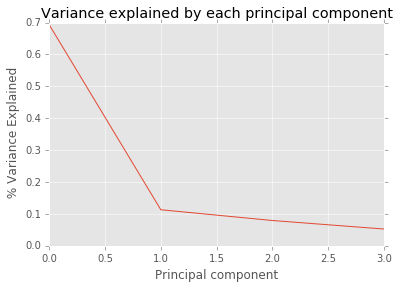

In [552]:
pca = decomposition.PCA(n_components=4)
X_r = pca.fit_transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.cla()
plt.plot(pca.explained_variance_ratio_)
plt.title('Variance explained by each principal component')
plt.ylabel(' % Variance Explained')
plt.xlabel('Principal component')
X_r

## Trying Decision Trees

In [ ]:
#policiesDT = pd.read_table('ChurnModelDatasetV6.txt',index_col='No_')

#policiesDT.columns = [c.replace(' ', '_') for c in policiesDT.columns]

#policiesDT.dropna(inplace=True)

#policiesDT.isnull().sum()

Columns = policies.columns.tolist()
Columns

In [ ]:
policies.Cancelled.mean() 

In [ ]:
#policiesDT['PlanTypeNew'] =  policiesDT.PlanType.map({'Accident & GVE':'Accident & GVE',
#                                                   'Accident & GVE & Routine':'Accident & GVE & Routine',
#                                                   'Accident':'Accident',
#                                                   'ASIA Accident & GVE':'Accident & GVE',
#                                                   'ASIA Accident & GVE & Routine':'Accident & GVE & Routine',
#                                                   'ASIA Accident':'Accident',
#                                                   'Accident & Routine':'Other','GVE':'Other','GVE & Routine':'Other'}) 


In [ ]:
#policiesDT['LastReviewOutcomeGroup'] =  policiesDT.LastReviewOutcome.map({'No review':'No review',
#                                                                             'Claim Decision Upheld':'Decision Upheld',
#                                                                         'Claim Decision Reversed':'Decision Reversed',
#                                                                         'Ex-gratia Claim':'Decision Reversed',
#                                                                         'PENDING':'Other',
#                                                                         'Exclusion Removed':'Decision Reversed',
#                                                                         'Underwriting Reversed':'Decision Reversed',
#                                                                         'Service Issue Resolved':'Other',
#                                                                         'Reponse Prepared and Sent':'Other',
#                                                                         'Underwriting Maintained':'Decision Upheld',
#                                                                         'Exclusion Maintained':'Other'})

In [ ]:
#policiesDT['MultiplePetsOwner'] =  policiesDT.OtherPets.map({0:0,1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,10:1,
#                                                        11:1,12:1,13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1,
#                                                        21:1,22:1,23:1,24:1,25:1,26:1,27:1,28:1,29:1,30:1,
#                                                        31:1,32:1,33:1})

In [555]:
d = policies[['Cancelled',
 'ClaimedInThePast',
 #'BenefitToClaimRatio',
 'breed_risk_group',
 'CXMonthsFromRenewal',
 #'TenureInMonths',
 #'NumberCalls',
 'ClaimReviews',
 #'MonthsSinceLastClaimReview',
 'PortalUser',
 'OtherMembershipNumber',
 #'MOnthsSinceLastClaim',
 'InsGenderFemale',
 'SpeciesDog',
 'PayFreqFortnight',
 'PayFreqMonth',
 'PayMethCC',
 'StateNSW',
 'StateVIC',
 'StateQLD',
 'StateSA',
 'StateACT',
 'StateTAS',
 'StateNT',
 'PlanAccGVERout',
 'PlanAccOnly',
 'PlanAccGVE',
 'PetAge00to01',
 'PetAge01to02',
 'PetAge02to03',
 'PetAge03to04',
 'PetAge04to05',
 'PetAge05to06',
 'PetAge06to07',
 'PetAge07to08',
 'PetAge08to09',
 'PetAge09to10',
 'IRSD_Dec10',
 'IRSD_Dec89',
 'IRSD_Dec67',
 'IRSD_Dec45',
 'IRSD_Dec23',
 'ChannelWeb',
 'PetAge00_01WhenJoin',
 'PetAge01_02WhenJoin',
 'PetAge02_03WhenJoin',
 'PetAge03_04WhenJoin',
 'PetAge04_05WhenJoin',
 'PetAge05_06WhenJoin',
 'PetAge06_07WhenJoin',
 'PetAge07_08WhenJoin',
 'PetAge08_09WhenJoin',
 'PetAge10PlusWhenJoin',
 'ClientAge00to19WhenJoined',
 'ClientAge20to29WhenJoined',
 'ClientAge30to39WhenJoined',
 'ClientAge40to49WhenJoined',
 'ClientAge50to59WhenJoined',
 'LastReviewOutcomeNoReview',
 'LastReviewOutcomeUpheld',
 'LastReviewOutcomeReversed',
 'Ntile5LastClaimAmount0',
 'Ntile5LastClaimAmount1',
 'Ntile5LastClaimAmount2',
 'Ntile5LastClaimAmount3',
 'Ntile5LastClaimAmount4',
 'Ntile5LastPaidAmount0',
 'Ntile5LastPaidAmount1',
 'Ntile5LastPaidAmount2',
 'Ntile5LastPaidAmount3',
 'Ntile5LastPaidAmount4',
 'PremiumDecile1',
 'PremiumDecile2',
 'PremiumDecile3',
 'PremiumDecile4',
 'PremiumDecile5',
 'PremiumDecile6',
 'PremiumDecile7',
 'PremiumDecile8',
 'PremiumDecile9',
 'MultiplePetsOwner'
               ] ]


#d = policiesDT[['Cancelled',
# 'PlanTypeNew',
# 'ClaimedInThePast',
# #'BenefitToClaimRatio',
# 'irsd_decile',
# 'premium_payment_period_code',
# 'payment_method_code',
# 'InsuredGender',
# #'premium',
# 'PremiumDecile',
# 'breed_risk_group',
# 'CXMonthsFromRenewal',
# #'TenureInMonths',
# #'PetAgeInMonths',
# #'ClientAgeInMonths',
# 'SalesChannel',
# #'pet_agegroup_when_join',
# #'client_agegroup_when_join',
# #'NumberCalls',
# 'ClaimReviews',
# #'MonthsSinceLastClaimReview',
# 'LastReviewOutcomeGroup',
# 'PortalUser',
# 'OtherMembershipNumber',
# 'species_code',
# 'State',
# 'Insured_Gender',
# 'Brand',
# 'MultiplePetsOwner',
# 'MOnthsSinceLastClaim',
# 'LastClaimStatus',
# 'Ntile5LastClaimAmount',
# 'Ntile5LastPaidAmount'
##'petAgeInYears',
##'ClientAgeInYears'
## 'ClientAgeInGroup',
## 'PetAgeGroup'
#               ] ]

In [556]:
d.Cancelled.value_counts() 
#267466

0    193099
1     74367
Name: Cancelled, dtype: int64

In [557]:
#d['PetAgeMths'] = (d.PetAgeInMonths <= 11).astype(int)

In [558]:
#d.Cancelled.mean() 
#cancellation rate
#d.groupby('ClaimedInThePast').Cancelled.mean()  #customer who did not claim have a higher cancellation rate
#d.groupby('breed_risk_group').Cancelled.mean()  #customer who did not claim have a higher cancellation rate
#d.groupby('CXMonthsFromRenewal').Cancelled.mean()  #customer are more likely to cancel around renewal time rate
#d.groupby('TenureInMonths').Cancelled.mean()  #The longer the pet is insured the less likely to leave
#d.groupby('PortalUser').Cancelled.mean()  #customers not signed to the portal have a higher cancellation rate
#d.groupby('OtherMembershipNumber').Cancelled.mean()  #customer with other memberships have lower cancellation rate
#d.groupby('MultiplePetsOwner').Cancelled.mean()  #customer with multiple pets have a higher cancellation rate
#d.groupby('MOnthsSinceLastClaim').Cancelled.mean()  #not normalised
#d.groupby('InsGenderFemale').Cancelled.mean()  #nothing from here
#d.groupby('SpeciesDog').Cancelled.mean()  #cats have a higher cancellation rate
#d.groupby('NumberCalls').Cancelled.mean()  #customers not signed to the portal have a higher cancellation rate



#d.groupby('PlanTypeNew').Cancelled.mean() # accident & GVE are less likely to cancel
#d.groupby( 'ClaimedInThePast').Cancelled.mean() #who has not claimed in the past is more likely to leave
####d.groupby( 'BenefitToClaimRatio').Cancelled.mean() 
#d.groupby( 'irsd_decile').Cancelled.mean() # the higher the seifa the less likely to cancel
#d.groupby('premium_payment_period_code').Cancelled.mean() #fortnightly payers have higher cancellation rate
#d.groupby( 'payment_method_code').Cancelled.mean() #similar
#d.groupby( 'InsuredGender').Cancelled.mean() #similar
#d.groupby( 'PremiumDecile').Cancelled.mean() #similar
#d.groupby( 'breed_risk_group').Cancelled.mean() # risk 0 are less likely to leave
#d.groupby( 'CXMonthsFromRenewal').Cancelled.mean() 
#d.groupby( 'SalesChannel').Cancelled.mean() #policies acquired online have lower cancellation rate
#d.groupby( 'pet_agegroup_when_join').Cancelled.mean() 
#d.groupby( 'client_agegroup_when_join').Cancelled.mean() 
#d.groupby( 'ClaimReviews').Cancelled.mean() #similar
#d.groupby( 'LastReviewOutcomeGroup').Cancelled.mean() #customers with review with decision upheld have higher CR
#d.groupby( 'PortalUser').Cancelled.mean() #portal user have lower CR
#d.groupby( 'OtherMembershipNumber').Cancelled.mean() #having a mn helps CR
#d.groupby( 'species_code').Cancelled.mean() #cats cancel more
#d.groupby( 'State').Cancelled.mean() 
#d.groupby( 'Insured_Gender').Cancelled.mean() #similar
#d.groupby( 'Brand').Cancelled.mean() 
#d.groupby( 'MultiplePetsOwner').Cancelled.mean() #more pets, more likely to leave
#d.groupby( 'LastClaimStatus').Cancelled.mean() 
d.groupby( 'ClaimReviews').Cancelled.mean() 
#d.groupby( 'Ntile5LastPaidAmount').Cancelled.mean() 
#d.groupby( 'ClientAgeInGroup').Cancelled.mean() 
#d.groupby( 'PetAgeMths').Cancelled.value_counts() 

ClaimReviews
0    0.278317
1    0.251292
Name: Cancelled, dtype: float64

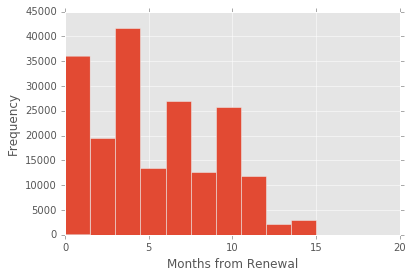

In [559]:
policies[policies.Cancelled == 0].CXMonthsFromRenewal.plot(kind='hist', xlim=(0,20))
plt.xlabel('Months from Renewal')

In [560]:
cancelled = d['Cancelled']
del d['Cancelled']
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267466 entries, 256909 to 56003
Data columns (total 75 columns):
ClaimedInThePast             267466 non-null int64
breed_risk_group             267466 non-null int64
CXMonthsFromRenewal          267466 non-null int64
ClaimReviews                 267466 non-null int64
PortalUser                   267466 non-null int64
OtherMembershipNumber        267466 non-null int64
InsGenderFemale              267466 non-null int64
SpeciesDog                   267466 non-null int64
PayFreqFortnight             267466 non-null int64
PayFreqMonth                 267466 non-null int64
PayMethCC                    267466 non-null int64
StateNSW                     267466 non-null int64
StateVIC                     267466 non-null int64
StateQLD                     267466 non-null int64
StateSA                      267466 non-null int64
StateACT                     267466 non-null int64
StateTAS                     267466 non-null int64
StateNT           

In [561]:
X_train, X_test, y_train, y_test = train_test_split(d,cancelled, random_state=1)

# Create a decision tree classifier instance (start out with a small tree for interpretability)
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# Fit the decision tree classifier
ctree.fit(X_train, y_train)

# Create a feature vector
features = d.columns.tolist()

features

['ClaimedInThePast',
 'breed_risk_group',
 'CXMonthsFromRenewal',
 'ClaimReviews',
 'PortalUser',
 'OtherMembershipNumber',
 'InsGenderFemale',
 'SpeciesDog',
 'PayFreqFortnight',
 'PayFreqMonth',
 'PayMethCC',
 'StateNSW',
 'StateVIC',
 'StateQLD',
 'StateSA',
 'StateACT',
 'StateTAS',
 'StateNT',
 'PlanAccGVERout',
 'PlanAccOnly',
 'PlanAccGVE',
 'PetAge00to01',
 'PetAge01to02',
 'PetAge02to03',
 'PetAge03to04',
 'PetAge04to05',
 'PetAge05to06',
 'PetAge06to07',
 'PetAge07to08',
 'PetAge08to09',
 'PetAge09to10',
 'IRSD_Dec10',
 'IRSD_Dec89',
 'IRSD_Dec67',
 'IRSD_Dec45',
 'IRSD_Dec23',
 'ChannelWeb',
 'PetAge00_01WhenJoin',
 'PetAge01_02WhenJoin',
 'PetAge02_03WhenJoin',
 'PetAge03_04WhenJoin',
 'PetAge04_05WhenJoin',
 'PetAge05_06WhenJoin',
 'PetAge06_07WhenJoin',
 'PetAge07_08WhenJoin',
 'PetAge08_09WhenJoin',
 'PetAge10PlusWhenJoin',
 'ClientAge00to19WhenJoined',
 'ClientAge20to29WhenJoined',
 'ClientAge30to39WhenJoined',
 'ClientAge40to49WhenJoined',
 'ClientAge50to59WhenJoined',

In [562]:
ctree.classes_

array([0, 1])

In [563]:
# Which features are the most important?
ctree.feature_importances_


array([ 0.26879523,  0.20389967,  0.5273051 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [564]:
# Clean up the output
pd.DataFrame(zip(features, ctree.feature_importances_)).sort_index(by=1, ascending=False)

/Users/flaviarossler/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


,0,1
2,CXMonthsFromRenewal,0.527305
0,ClaimedInThePast,0.268795
1,breed_risk_group,0.203900
73,PremiumDecile9,0.000000
47,ClientAge00to19WhenJoined,0.000000
53,LastReviewOutcomeUpheld,0.000000
52,LastReviewOutcomeNoReview,0.000000
51,ClientAge50to59WhenJoined,0.000000
50,ClientAge40to49WhenJoined,0.000000
49,ClientAge30to39WhenJoined,0.000000


In [565]:
# Make predictions on the test set
preds = ctree.predict(X_test)

# Calculate accuracy
metrics.accuracy_score(y_test, preds)

0.72104326498870897

In [566]:
# Confusion matrix
pd.crosstab(y_test, preds, rownames=['actual'], colnames=['predicted'])

# Make predictions on the test set using predict_proba
probs = ctree.predict_proba(X_test)[:,1]

# Calculate the AUC metric
metrics.roc_auc_score(y_test, probs)

# Decision Trees have notorouisly high variance, so what can we do
# to better estimate the out of sample error of a high variance model?

0.65474037559156639

2016-05-28 10:06:02.798 dot[1653:507] CoreText performance note: Client called CTFontCreateWithName() using name "helvetica" and got font with PostScript name "Helvetica". For best performance, only use PostScript names when calling this API.
2016-05-28 10:06:02.801 dot[1653:507] CoreText performance note: Set a breakpoint on CTFontLogSuboptimalRequest to debug.
2016-05-28 10:06:02.805 dot[1653:507] CoreText performance note: Client called CTFontCreateWithName() using name "helvetica" and got font with PostScript name "Helvetica". For best performance, only use PostScript names when calling this API.
2016-05-28 10:06:02.805 dot[1653:507] CoreText performance note: Client called CTFontCreateWithName() using name "helvetica" and got font with PostScript name "Helvetica". For best performance, only use PostScript names when calling this API.
2016-05-28 10:06:02.806 dot[1653:507] CoreText performance note: Client called CTFontCreateWithName() using name "helvetica" and got font with PostSc

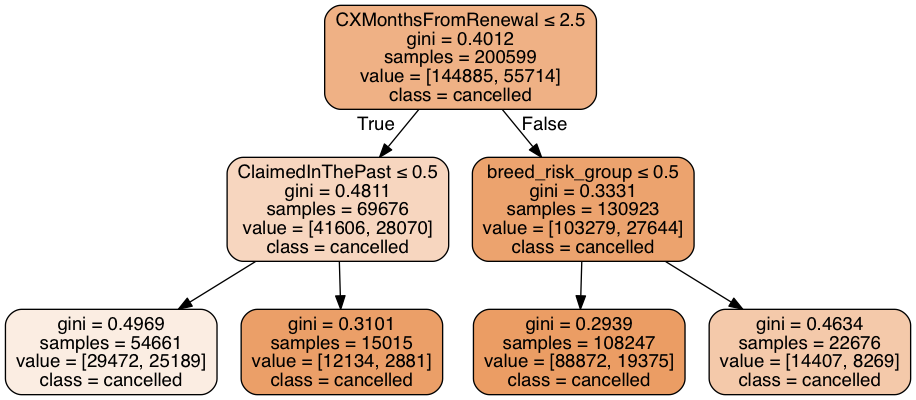

In [567]:
import StringIO
from IPython.display import Image
import pydot
# make sure pydot and graphviz are installed 
# if problems see here:
# http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will/17902926#17902926

dot_data = StringIO.StringIO()  
tree.export_graphviz(
    ctree, 
    out_file=dot_data,
    feature_names=features,  
    class_names=["cancelled","active"],  
    filled=True, 
    rounded=True,  
    special_characters=True
)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [568]:
policies.describe()


,Cancelled,ClaimedInThePast,BenefitToClaimRatio,breed_risk_group,CXMonthsFromRenewal,TenureInMonths,NumberCalls,ClaimReviews,MonthsSinceLastClaimReview,PortalUser,...,PremiumDecile1,PremiumDecile2,PremiumDecile3,PremiumDecile4,PremiumDecile5,PremiumDecile6,PremiumDecile7,PremiumDecile8,PremiumDecile9,MultiplePetsOwner
count,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,...,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000,267466.000000
mean,0.278043,0.306779,0.115534,0.679137,4.804786,10.648909,1.811539,0.010132,13.471245,0.170807,...,0.099830,0.099904,0.099983,0.099987,0.100069,0.099998,0.100013,0.100147,0.100035,0.440718
std,0.448035,0.461158,0.236117,1.502114,3.687427,8.128869,2.996036,0.100147,8.240601,0.376341,...,0.299773,0.299873,0.299978,0.299983,0.300092,0.299998,0.300018,0.300197,0.300047,0.496474
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,4.000000,9.000000,1.000000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,8.000000,17.000000,2.000000,0.000000,20.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.100062,6.000000,15.000000,37.000000,139.000000,1.000000,28.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [571]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# compare AUC using cross-validation
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, d, cancelled, cv=10, scoring='roc_auc').mean()

0.77395986605428679

In [572]:
cross_val_score(ctree, d, cancelled, cv=10, scoring='roc_auc').mean()

0.65669579720720894

In [573]:
from sklearn.grid_search import GridSearchCV

# check CV score for max depth = 3
ctree = tree.DecisionTreeClassifier(max_depth=3)
np.mean(cross_val_score(ctree, d, cancelled, cv=5, scoring='roc_auc'))

0.65851834832571965

In [574]:
# check CV score for max depth = 10
ctree = tree.DecisionTreeClassifier(max_depth=10)
np.mean(cross_val_score(ctree, d, cancelled, cv=5, scoring='roc_auc'))


0.70634737812506498

In [575]:
# Conduct a grid search for the best tree depth
ctree = tree.DecisionTreeClassifier(random_state=3)
depth_range = range(1, 20)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5, scoring='roc_auc')
grid.fit(d, cancelled)


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=3, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

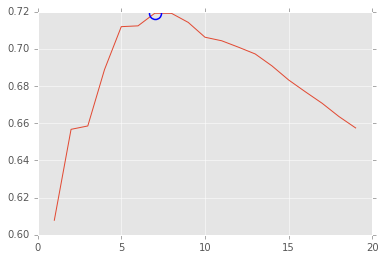

In [577]:

# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]


# Plot the results of the grid search
plt.figure()
plt.plot(depth_range, grid_mean_scores)
plt.hold(True)
plt.grid(True)
plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='b')


In [579]:
# Get the best estimator
best = grid.best_estimator_

cross_val_score(logreg, d, cancelled, cv=10, scoring='roc_auc').mean()

0.77397616071199338

In [580]:
cross_val_score(best, d, cancelled, cv=10, scoring='roc_auc').mean()

0.76559836699332173